# This IPython notebook is a document for deriving monthly proportion of precipitation for different trajectory cluster during NCEP/NCAR-covered period
    by Xia and Butorovic for JGR-Atmospheres manuscript

Activate packages

In [1]:
import pysplit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({"mathtext.default":"regular"})

Wrap trajectories into trajgroups and it takes several minutes to run

In [2]:
trajgroup_0500 = pysplit.make_trajectorygroup(r"C:/trajectories/PA_NCAR_new/0500m/*PA*0500*")
print("number of 500-m trajectories:",trajgroup_0500.trajcount)

trajgroup_1000 = pysplit.make_trajectorygroup(r"C:/trajectories/PA_NCAR_new/1000m/*PA*1000*")
print("number of 1000-m trajectories:",trajgroup_1000.trajcount)

trajgroup_1500 = pysplit.make_trajectorygroup(r"C:/trajectories/PA_NCAR_new/1500m/*PA*1500*")
print("number of 1500-m trajectories:",trajgroup_1500.trajcount)

trajgroup_2000 = pysplit.make_trajectorygroup(r"C:/trajectories/PA_NCAR_new/2000m/*PA*2000*")
print("number of 2000-m trajectories:",trajgroup_2000.trajcount)

number of 500-m trajectories: 3676
number of 1000-m trajectories: 3676
number of 1500-m trajectories: 3676
number of 2000-m trajectories: 3676


Define a function to cluster trajectory into four distal clusters clusters
* If trajectory cluster is identified, then trajectory is put into list (e.g., cluster_dE) of that cluster.
* The identifier of trajectory cluster is also put into a list (e.g., cluster_list_distal) as a sequence for following analysis

In [3]:
def cluster_traj_distal(trajgroup):
    cluster_dE,cluster_dN,cluster_dW,cluster_dS = [],[],[],[]
    cluster_list_distal = []
    for traj in trajgroup:
        cluster = "default"
        t = 0
        for step in range(0,120):
            if traj.data.geometry.loc[t].y < traj.data.geometry.loc[t].x + 18:
                if traj.data.geometry.loc[t].y > -2.5 * traj.data.geometry.loc[t].x - 223.5:
                    if traj.data.geometry.loc[t].y > -0.5 * traj.data.geometry.loc[t].x -87.5:
                        cluster = "dE"
                        cluster_dE.append(traj)
            if traj.data.geometry.loc[t].y > -48:
                if traj.data.geometry.loc[t].y > -7 * traj.data.geometry.loc[t].x - 559:
                    if traj.data.geometry.loc[t].y > traj.data.geometry.loc[t].x + 18:
                        cluster = "dN"
                        cluster_dN.append(traj)
            if traj.data.geometry.loc[t].y < -7 * traj.data.geometry.loc[t].x - 559:
                cluster = "dW"
                cluster_dW.append(traj)
            if traj.data.geometry.loc[t].y < -55:
                if traj.data.geometry.loc[t].y > -7 * traj.data.geometry.loc[t].x - 559:
                    if traj.data.geometry.loc[t].y < -0.5 * traj.data.geometry.loc[t].x - 87.5:
                        cluster = "dS"
                        cluster_dS.append(traj)
            if cluster != "default":
                break
            t = t - 1
        if cluster == "default":
            print("no boundary crossed on yr mn dy hr:",traj.data.DateTime.dt.year[0],traj.data.DateTime.dt.month[0],\
                  traj.data.DateTime.dt.day[0],traj.data.DateTime.dt.hour[0])
            # check to see if any trajectory did not cross any boundary
        cluster_list_distal.append(cluster)
    return cluster_list_distal,cluster_dE,cluster_dN,cluster_dW,cluster_dS

cluster_list_distal_0500,cluster_dE_0500,cluster_dN_0500,cluster_dW_0500,cluster_dS_0500 = cluster_traj_distal(trajgroup_0500)
cluster_list_distal_1000,cluster_dE_1000,cluster_dN_1000,cluster_dW_1000,cluster_dS_1000 = cluster_traj_distal(trajgroup_1000)
cluster_list_distal_1500,cluster_dE_1500,cluster_dN_1500,cluster_dW_1500,cluster_dS_1500 = cluster_traj_distal(trajgroup_1500)
cluster_list_distal_2000,cluster_dE_2000,cluster_dN_2000,cluster_dW_2000,cluster_dS_2000 = cluster_traj_distal(trajgroup_2000)

Define a function to calculate monthly proportion of each cluster's precipitation

In [4]:
df_precipitation = pd.read_excel("Airport data/Punta Arenas AP precipitation.xlsx",sheet_name="6hour")
df_precip = df_precipitation[df_precipitation["6hr precipitation"] > 0].reset_index(drop = True)

def calculate_monthly(distal,trajgroup):
    year,month,day,hour = [],[],[],[]
    for traj in trajgroup:
        # attention: PySPLIT trajgroup takes trajectory starting from year 2000-2004 first and then read year 19**
        # this does not impact our results as the code avoids the problem
        # because 1990010100 and 2000010100 has no precipitation, so the transition date problem is avoided as well
        year.append(traj.data.DateTime.dt.year[0])
        month.append(traj.data.DateTime.dt.month[0])
        day.append(traj.data.DateTime.dt.day[0])
        hour.append(traj.data.DateTime.dt.hour[0])
    df = pd.DataFrame(list(zip(year,month,day,hour)),columns = ["year","month","day","hour"])
    df = pd.merge(df, df_precip)
    year,month = [],[]
    dE_ratio,dN_ratio,dW_ratio,dS_ratio = [],[],[],[]
    for yr in range(1990,2005):
        for mn in range(1,13):
            dE,dN,dW,dS,monthly = 0,0,0,0,0
            for i in range(len(df)):
                if df["year"][i] == yr and df["month"][i] == mn:
                    if df["day"][i] != 1 or df["hour"][i] != 0:
                        # here day 0 hour 00 precipitation for each month should be considered as the last month's precipitation
                        if distal[i] == "dE":
                            dE = dE + df["6hr precipitation"][i]
                        if distal[i] == "dN":
                            dN = dN + df["6hr precipitation"][i]
                        if distal[i] == "dW":
                            dW = dW + df["6hr precipitation"][i]
                        if distal[i] == "dS":
                            dS = dS + df["6hr precipitation"][i]
                        monthly = monthly + df["6hr precipitation"][i]
                    if i != len(df)-1:
                        if df["day"][i+1] == 1 and df["hour"][i+1] == 0:
                            # here we add up day 0 hour 00 precipitation from next month
                            if distal[i+1] == "dE":
                                dE = dE + df["6hr precipitation"][i+1]
                            if distal[i+1] == "dN":
                                dN = dN + df["6hr precipitation"][i+1]
                            if distal[i+1] == "dW":
                                dW = dW + df["6hr precipitation"][i+1]
                            if distal[i+1] == "dS":
                                dS = dS + df["6hr precipitation"][i+1]
                            monthly = monthly + df["6hr precipitation"][i+1]
            year.append(yr)
            month.append(mn)
            dE_ratio.append(dE/monthly*100)
            dN_ratio.append(dN/monthly*100)
            dW_ratio.append(dW/monthly*100)
            dS_ratio.append(dS/monthly*100)
    return pd.DataFrame(list(zip(year,month,dE_ratio,dN_ratio,dW_ratio,dS_ratio)),
                        columns = ["year","month","dE%","dN%","dW%","dS%"])
df_results_0500 = calculate_monthly(cluster_list_distal_0500,trajgroup_0500)
df_results_1000 = calculate_monthly(cluster_list_distal_1000,trajgroup_1000)
df_results_1500 = calculate_monthly(cluster_list_distal_1500,trajgroup_1500)
df_results_2000 = calculate_monthly(cluster_list_distal_2000,trajgroup_2000)

Visualize results

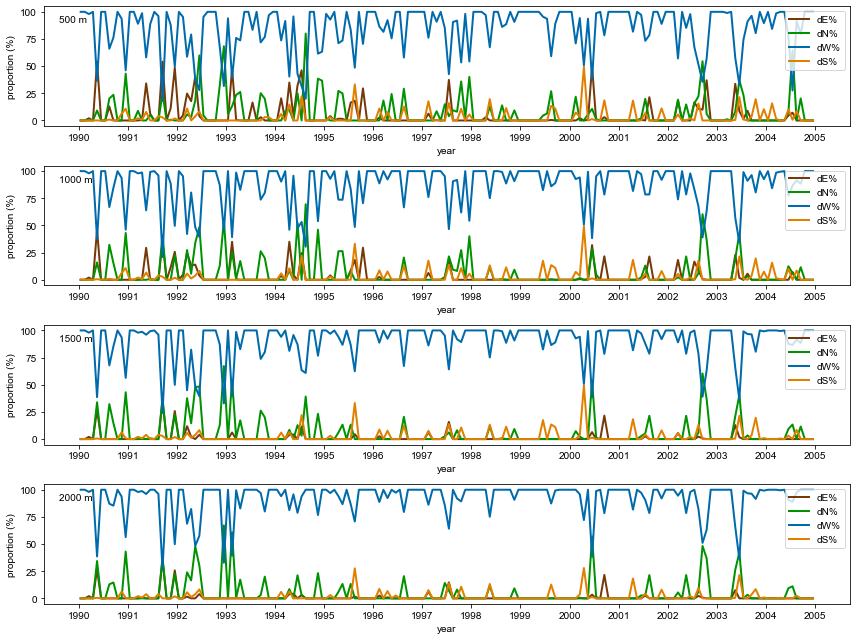

In [5]:
plt.figure(figsize=(12,9))
def plot_time_series(data,sub,m):
    plt.subplot(4,1,sub)
    plt.plot(data["year"]+(data["month"]*2-1)/24,data["dE%"],linewidth=2,color="#753909")
    plt.plot(data["year"]+(data["month"]*2-1)/24,data["dN%"],linewidth=2,color="#009300")
    plt.plot(data["year"]+(data["month"]*2-1)/24,data["dW%"],linewidth=2,color="#006BAC")
    plt.plot(data["year"]+(data["month"]*2-1)/24,data["dS%"],linewidth=2,color="#E18000")
    plt.xticks(range(1990, 2006, 1))
    plt.xlabel("year")
    plt.ylabel("proportion (%)")
    plt.text(1989.6,90,m)
    legend=plt.legend(("dE%","dN%","dW%","dS%"),loc=1)
plot_time_series(df_results_0500,1,"500 m")
plot_time_series(df_results_1000,2,"1000 m")
plot_time_series(df_results_1500,3,"1500 m")
plot_time_series(df_results_2000,4,"2000 m")
plt.tight_layout()

Plot GNIP data versus GHCN temperature
* GNIP data are filtered and only d18O data ranging from -17 to -3 permil (d-excess >= -10) were used.
* The regression line was used to calculate d18O residual.

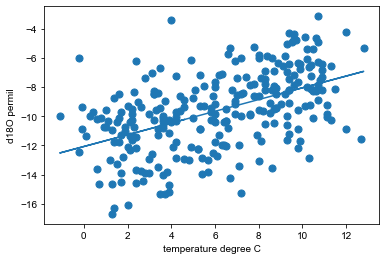

In [6]:
df_GNIP = pd.read_excel("GNIP.xlsx",sheet_name="Sheet1")
df_GNIP = df_GNIP[(df_GNIP["d18O"]<=-3) & (df_GNIP["d-excess"]>=-10) & (df_GNIP["d18O"]>=-17)].reset_index()
plt.scatter(df_GNIP["GHCN temp"],df_GNIP["d18O"],s=50)
# one GHCN temperature observation gap was filled by GNIP temperature data 
plt.xlabel("temperature degree C")
plt.ylabel("d18O permil")
m, b = np.polyfit(df_GNIP["GHCN temp"],df_GNIP["d18O"], 1)
plt.plot(df_GNIP["GHCN temp"],m*df_GNIP["GHCN temp"]+b)

Calculate d18O residual

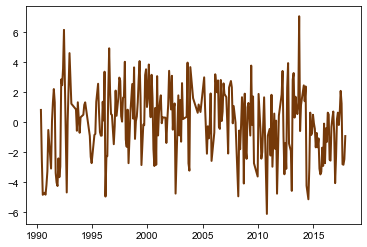

In [7]:
d18O_residual = []
for i in range(0,len(df_GNIP.d18O)):
    d18O_residual.append(df_GNIP["d18O"][i]-(m*df_GNIP["GHCN temp"][i]+b))
df_GNIP["d18O residual"] = d18O_residual
plt.plot(df_GNIP["year"]+(df_GNIP["month"]*2-1)/24,df_GNIP["d18O residual"],linewidth=2,color="#753909")

Calculate trajectory frequency grid using 2000m-trajgroup as an example

In [8]:
array = []
for traj in trajgroup_2000:
    t=0
    for step in range(0,121):
        row = (int((round(traj.data.geometry.loc[t].y)))+90)*361+int((round(traj.data.geometry.loc[t].x)))+180
        array.append(row)
        t=t-1
# read every coordinate data along each trajectory into "array" list

count = []
for i in range(0,65341):
    count.append(array.count(i))
# count each grid

freq = []
for i in count:
    freq.append(i/sum(count)*100*121)
# calculate grid frequency

x = np.arange(-180,181,1)
y = np.arange(-90,91,1)
X, Y = np.meshgrid(x, y)
Z = np.reshape(freq, (181,361))
# get ready for frequency plot

Make the trajectory frequency plot

C:\Users\Zhengyu\Anaconda3\lib\site-packages\pysplit\mapdesigner.py:315: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  ax=ax)
C:\Users\Zhengyu\Anaconda3\lib\site-packages\pysplit\mapdesigner.py:327: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  basemap.drawcountries(zorder=self.zborder)


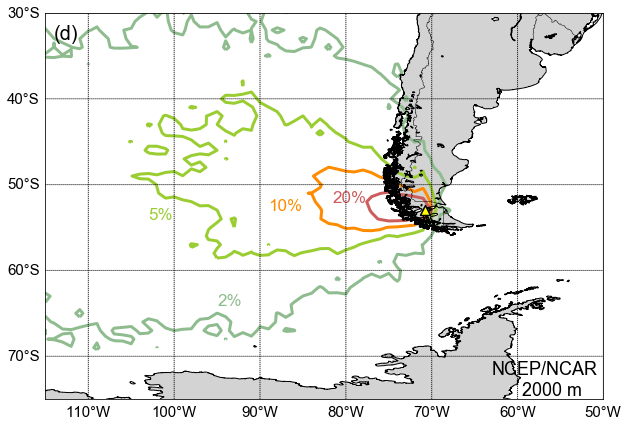

In [9]:
mapcorners = [-115, -75, -50, -30]
standard_pm = None
bmap_params = pysplit.MapDesign(mapcorners,standard_pm,mapcolor=None,latlon_spacing=(10,10),
                                latlon_labelspacing=(10,10),
                                lon_labels=["bottom"], latlon_fs=15,
                                drawoutlines=True,resolution="h",area_threshold=100,
                                zmapbound=100)
bmap = bmap_params.make_basemap()
bmap.drawlsmask(land_color = "#d3d3d3", ocean_color="white")
bmap.scatter(-70.8333,-53.0,marker="^",c="yellow",zorder=20, s=100,edgecolors="black",linewidths=1.5)
plt.contour(X,Y,Z,levels=(2,5,10,20),colors=("darkseagreen","yellowgreen","darkorange","indianred"),linewidths=3)

plt.text(-81.5,-52,"20%",fontsize=17,color="indianred")
plt.text(-89,-53,"10%",fontsize=17,color="darkorange")
plt.text(-103,-54,"5%",fontsize=17,color="yellowgreen")
plt.text(-95,-64,"2%",fontsize=17,color="darkseagreen")
plt.text(-114,-33,"(d)",fontsize=20)
plt.text(-63,-74.5,"NCEP/NCAR\n      2000 m",fontsize=18)
plt.savefig("NCAR2000freq.pdf")

Correlation analysis

In [10]:
df = pd.merge(df_GNIP, df_results_0500)
df_winter=df[(df["month"]>=6) & (df["month"]<=8)]
df_spring=df[(df["month"]>=9) & (df["month"]<=11)]
df_summer=df[(df["month"]>=12) | (df["month"]<=2)]
df_autumn=df[(df["month"]>=3) & (df["month"]<=5)]
from scipy.stats import pearsonr
r1,p1=pearsonr(df["d-excess"],df["dE%"])
print(r1,p1)
r1,p1=pearsonr(df_winter["d-excess"],df_winter["dE%"])
print(r1,p1)
r1,p1=pearsonr(df_spring["d-excess"],df_spring["dE%"])
print(r1,p1)
r1,p1=pearsonr(df_summer["d-excess"],df_summer["dE%"])
print(r1,p1)
r1,p1=pearsonr(df_autumn["d-excess"],df_autumn["dE%"])
print(r1,p1)

0.21266605471193684 0.01327241352101854
0.19273141131543903 0.29059139735791284
0.2440708992624731 0.13974750458648777
0.3663655451972092 0.03599415725926788
0.03118596500864021 0.8654532152208174


Along-trajectory pecific humidity and rainfall rate analysis

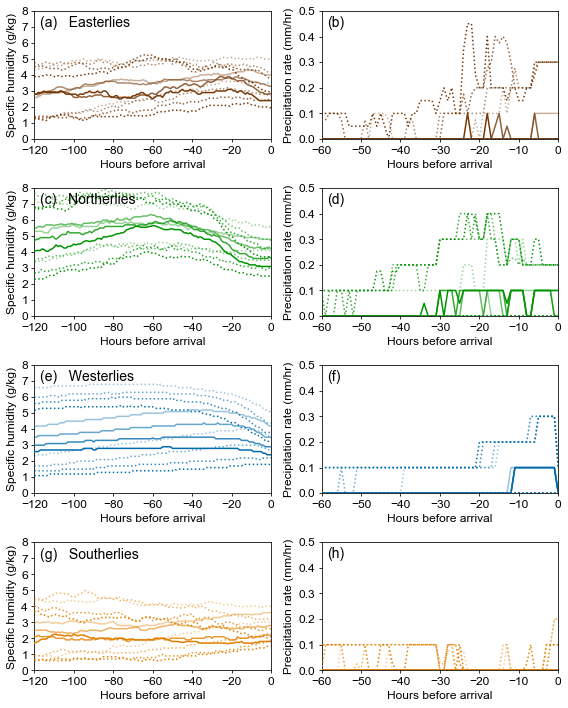

In [11]:
def get_percentile_SH(trajgroup,perc):
    SH=[]
    for hr in range(-120,1,1):
        SH_list=[]
        for traj in trajgroup:
            SH_list.append(traj.data.Specific_Humidity[hr])
        SH.append(np.quantile(SH_list,perc))
    return(SH)
def get_percentile_RR(trajgroup,perc):
    RR=[]
    for hr in range(-120,1,1):
        RR_list=[]
        for traj in trajgroup:
            RR_list.append(traj.data.Rainfall[hr])
        RR.append(np.quantile(RR_list,perc))
    return(RR)

plt.figure(figsize=(8,10))

def plot_SH(cluster,c,a):
    plt.plot(range(-120,1,1),get_percentile_SH(cluster,0.5),color=c,alpha=a,zorder=20)
    plt.plot(range(-120,1,1),get_percentile_SH(cluster,0.25),color=c,linestyle="dotted",alpha=a,zorder=10)
    plt.plot(range(-120,1,1),get_percentile_SH(cluster,0.75),color=c,linestyle="dotted",alpha=a,zorder=10)
    plt.xlabel("Hours before arrival",fontsize=12)
    plt.ylabel("Specific humidity (g/kg)",fontsize=12)
    plt.tick_params(axis="both",which="major",labelsize=12,length=3)
    plt.xlim(xmin=-120,xmax=0)
    plt.xticks(range(-120,20,20))
    plt.ylim(ymin=0,ymax=8)
    plt.yticks(range(0,9,1))
def plot_RR(cluster,c,a):
    plt.plot(range(-120,1,1),get_percentile_RR(cluster,0.5),color=c,alpha=a,zorder=20)
    plt.plot(range(-120,1,1),get_percentile_RR(cluster,0.25),color=c,linestyle="dotted",alpha=a,zorder=10)
    plt.plot(range(-120,1,1),get_percentile_RR(cluster,0.75),color=c,linestyle="dotted",alpha=a,zorder=10)
    plt.xlabel("Hours before arrival",fontsize=12)
    plt.ylabel("Precipitation rate (mm/hr)",fontsize=12)
    plt.tick_params(axis="both",which="major",labelsize=12,length=3)
    plt.xlim(xmin=-60,xmax=0)
    plt.xticks(range(-60,10,10))
    plt.ylim(ymin=0,ymax=0.5)

plt.subplot(4,2,1)
plot_SH(cluster_dE_0500,"#753909",0.4)
plot_SH(cluster_dE_1000,"#753909",0.6)
plot_SH(cluster_dE_1500,"#753909",0.8)
plot_SH(cluster_dE_2000,"#753909",1)
plt.text(-117,7,"(a)   Easterlies",fontsize=14,zorder=50)
plt.subplot(4,2,2)
plot_RR(cluster_dE_0500,"#753909",0.4)
plot_RR(cluster_dE_1000,"#753909",0.6)
plot_RR(cluster_dE_1500,"#753909",0.8)
plot_RR(cluster_dE_2000,"#753909",1)
plt.text(-58.5,0.44,"(b)",fontsize=14)
plt.subplot(4,2,3)
plot_SH(cluster_dN_0500,"#009300",0.4)
plot_SH(cluster_dN_1000,"#009300",0.6)
plot_SH(cluster_dN_1500,"#009300",0.8)
plot_SH(cluster_dN_2000,"#009300",1)
plt.text(-117,7,"(c)   Northerlies",fontsize=14,zorder=50)
plt.subplot(4,2,4)
plot_RR(cluster_dN_0500,"#009300",0.4)
plot_RR(cluster_dN_1000,"#009300",0.6)
plot_RR(cluster_dN_1500,"#009300",0.8)
plot_RR(cluster_dN_2000,"#009300",1)
plt.text(-58.5,0.44,"(d)",fontsize=14)
plt.subplot(4,2,5)
plot_SH(cluster_dW_0500,"#006BAC",0.4)
plot_SH(cluster_dW_1000,"#006BAC",0.6)
plot_SH(cluster_dW_1500,"#006BAC",0.8)
plot_SH(cluster_dW_2000,"#006BAC",1)
plt.text(-117,7,"(e)   Westerlies",fontsize=14,zorder=50)
plt.subplot(4,2,6)
plot_RR(cluster_dW_0500,"#006BAC",0.4)
plot_RR(cluster_dW_1000,"#006BAC",0.6)
plot_RR(cluster_dW_1500,"#006BAC",0.8)
plot_RR(cluster_dW_2000,"#006BAC",1)
plt.text(-58.5,0.44,"(f)",fontsize=14)
plt.subplot(4,2,7)
plot_SH(cluster_dS_0500,"#E18000",0.4)
plot_SH(cluster_dS_1000,"#E18000",0.6)
plot_SH(cluster_dS_1500,"#E18000",0.8)
plot_SH(cluster_dS_2000,"#E18000",1)
plt.text(-117,7,"(g)   Southerlies",fontsize=14,zorder=50)
plt.subplot(4,2,8)
plot_RR(cluster_dS_0500,"#E18000",0.4)
plot_RR(cluster_dS_1000,"#E18000",0.6)
plot_RR(cluster_dS_1500,"#E18000",0.8)
plot_RR(cluster_dS_2000,"#E18000",1)
plt.text(-58.5,0.44,"(h)",fontsize=14)

plt.tight_layout(w_pad=1,h_pad=1)
plt.savefig("Figure 6_NCAR.pdf",bbox_inches="tight")

Histogram visualization

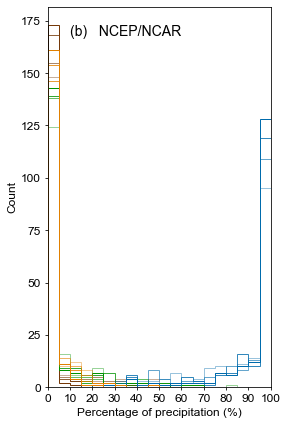

In [12]:
plt.figure(figsize=(4,7))
def plot_hist(cluster,c):    
    plt.hist(df_results_2000[cluster],bins=range(0,105,5),histtype="step",alpha=1,color=c)
    plt.hist(df_results_1500[cluster],bins=range(0,105,5),histtype="step",alpha=0.8,color=c)
    plt.hist(df_results_1000[cluster],bins=range(0,105,5),histtype="step",alpha=0.6,color=c)
    plt.hist(df_results_0500[cluster],bins=range(0,105,5),histtype="step",alpha=0.4,color=c)
plot_hist("dE%","#753909")
plot_hist("dN%","#009300")
plot_hist("dW%","#006BAC")
plot_hist("dS%","#E18000")
plt.xlabel("Percentage of precipitation (%)",fontsize=12)
plt.ylabel("Count",fontsize=12)
plt.tick_params(axis="both",which="major",labelsize=12,length=3)
plt.xlim(xmin=0,xmax=100)
plt.xticks(range(0,110,10))
plt.text(10,168,"(b)   NCEP/NCAR",fontsize=14,zorder=50)
plt.savefig("hist2.pdf",bbox_inches="tight")

Cumulative precipitation plot

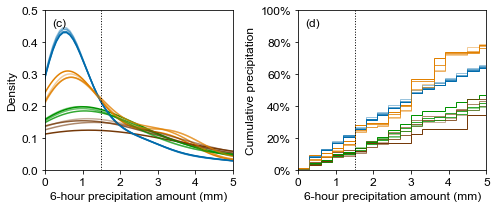

In [13]:
plt.figure(figsize=(7,3))
df_precip_NCEP=df_precip[df_precip["year"]<=2004].reset_index(drop=True)

def plot_amount_hist(cluster,a):
    dE_hist,dN_hist,dW_hist,dS_hist=[],[],[],[]
    for i in range(len(cluster)):
        if cluster[i]=="dE":
            if i<=1192:
                dE_hist.append(df_precip_NCEP["6hr precipitation"][i+2483])
            else:
                dE_hist.append(df_precip_NCEP["6hr precipitation"][i-1193])
        if cluster[i]=="dN":
            if i<=1192:
                dN_hist.append(df_precip_NCEP["6hr precipitation"][i+2483])
            else:
                dN_hist.append(df_precip_NCEP["6hr precipitation"][i-1193])
        if cluster[i]=="dW":
            if i<=1192:
                dW_hist.append(df_precip_NCEP["6hr precipitation"][i+2483])
            else:
                dW_hist.append(df_precip_NCEP["6hr precipitation"][i-1193])
        if cluster[i]=="dS":
            if i<=1192:
                dS_hist.append(df_precip_NCEP["6hr precipitation"][i+2483])
            else:
                dS_hist.append(df_precip_NCEP["6hr precipitation"][i-1193])
    ax1 = pd.Series(dE_hist).plot.kde(fontsize = 12,color="#753909",alpha=a)
    ax1 = pd.Series(dN_hist).plot.kde(fontsize = 12,color="#009300",alpha=a)
    ax1 = pd.Series(dW_hist).plot.kde(fontsize = 12,color="#006BAC",alpha=a)
    ax1 = pd.Series(dS_hist).plot.kde(fontsize = 12,color="#E18000",alpha=a)
plt.subplot(1,2,1)
plot_amount_hist(cluster_list_distal_2000,1)
plot_amount_hist(cluster_list_distal_1500,0.8)
plot_amount_hist(cluster_list_distal_1000,0.6)
plot_amount_hist(cluster_list_distal_0500,0.4)
plt.plot([1.5,1.5],[0,1],color="black",linewidth=1,linestyle="dotted")
plt.xlim(xmin=0,xmax=5)
plt.ylim(ymin=0,ymax=0.5)
plt.xlabel("6-hour precipitation amount (mm)",fontsize=12)
plt.ylabel("Density",fontsize=12)
plt.text(0.2,0.45,"(c)",fontsize=12)

def plot_cumu_hist(cluster,a):
    dE_hist,dN_hist,dW_hist,dS_hist=[],[],[],[]
    for i in range(len(cluster)):
        if cluster[i]=="dE":
            if i<=1192:
                dE_hist.append(df_precip_NCEP["6hr precipitation"][i+2483])
            else:
                dE_hist.append(df_precip_NCEP["6hr precipitation"][i-1193])
        if cluster[i]=="dN":
            if i<=1192:
                dN_hist.append(df_precip_NCEP["6hr precipitation"][i+2483])
            else:
                dN_hist.append(df_precip_NCEP["6hr precipitation"][i-1193])
        if cluster[i]=="dW":
            if i<=1192:
                dW_hist.append(df_precip_NCEP["6hr precipitation"][i+2483])
            else:
                dW_hist.append(df_precip_NCEP["6hr precipitation"][i-1193])
        if cluster[i]=="dS":
            if i<=1192:
                dS_hist.append(df_precip_NCEP["6hr precipitation"][i+2483])
            else:
                dS_hist.append(df_precip_NCEP["6hr precipitation"][i-1193])
    ax2 = pd.Series(dE_hist).plot.hist(fontsize = 12,color="#753909",cumulative=True,weights=dE_hist,density=True,
                                       alpha=a,bins=np.arange(0,100,0.3),histtype="step")
    ax2 = pd.Series(dN_hist).plot.hist(fontsize = 12,color="#009300",cumulative=True,weights=dN_hist,density=True,
                                       alpha=a,bins=np.arange(0,100,0.3),histtype="step")
    ax2 = pd.Series(dW_hist).plot.hist(fontsize = 12,color="#006BAC",cumulative=True,weights=dW_hist,density=True,
                                       alpha=a,bins=np.arange(0,100,0.3),histtype="step")
    ax2 = pd.Series(dS_hist).plot.hist(fontsize = 12,color="#E18000",cumulative=True,weights=dS_hist,density=True,
                                       alpha=a,bins=np.arange(0,100,0.3),histtype="step")
plt.subplot(1,2,2)
plot_cumu_hist(cluster_list_distal_2000,1)
plot_cumu_hist(cluster_list_distal_1500,0.8)
plot_cumu_hist(cluster_list_distal_1000,0.6)
plot_cumu_hist(cluster_list_distal_0500,0.4)
plt.plot([1.5,1.5],[0,1],color="black",linewidth=1,linestyle="dotted")
plt.xlim(xmin=0,xmax=5)
plt.ylim(ymin=0,ymax=1)
plt.yticks([0,0.2,0.4,0.6,0.8,1],labels=["0%","20%","40%","60%","80%","100%"])
plt.xlabel("6-hour precipitation amount (mm)",fontsize=12)
plt.ylabel("Cumulative precipitation",fontsize=12)
plt.text(0.2,0.9,"(d)",fontsize=12)
plt.tight_layout(w_pad=1)
plt.savefig("density_NCEP.pdf",bbox_inches="tight")